# Clasificador de Géneros Musicales con Deep Learning
En este proyecto, utilizaremos el dataset **GTZAN** para entrenar una Red Neuronal Convolucional (CNN). El objetivo es que el modelo aprenda a identificar patrones en las frecuencias de audio para clasificar canciones en 10 géneros diferentes.

### 1. Preparación del entorno
Instalamos y cargamos las librerías necesarias. Utilizaremos **Librosa** para el procesamiento de señales de audio y **TensorFlow/Keras** para construir la arquitectura de la red.

In [2]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


### 2. Adquisición de Datos vía KaggleHub
Utilizamos la librería kagglehub para descargar la versión más reciente del dataset GTZAN. Este método es el más robusto ya que garantiza el acceso a los datos originales de forma programática.

In [3]:
import kagglehub
import os
import shutil

# 1. Descargar el dataset completo
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Ruta de descarga:", path)

# 2. Vamos a mover los audios a nuestra carpeta de trabajo para que sea más fácil de usar
# El dataset de Kaggle tiene una carpeta llamada 'Data/genres_original'
source_path = os.path.join(path, "Data/genres_original")
dest_path = "genres"

if os.path.exists(source_path):
    if os.path.exists(dest_path):
        shutil.rmtree(dest_path)
    shutil.copytree(source_path, dest_path)
    print("¡Archivos movidos con éxito a la carpeta /genres!")
else:
    print("No se encontró la carpeta original, revisa el contenido de:", path)

# 3. Listar los géneros para confirmar
!ls genres

100%|██████████| 1.21G/1.21G [00:12<00:00, 106MB/s]

Extracting files...


Ruta de descarga: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
¡Archivos movidos con éxito a la carpeta /genres!
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


### 3. Procesamiento de Audio: Extracción de MFCC

Para que la red neuronal pueda procesar el sonido, transformamos las ondas de audio en **Coeficientes Cepstrales en las Frecuencias de Mel (MFCC)**.

**Estrategia:**

1. Dividimos cada pista de 30s en 10 segmentos de 3s para aumentar nuestro dataset a 10,000 muestras.

2. Extraemos 13 coeficientes MFCC por cada segmento.

3. Almacenamos los datos en un archivo JSON para optimizar la memoria y facilitar el entrenamiento futuro.

In [4]:
import json
import os
import math
import librosa

# Configuración de rutas
DATASET_PATH = "genres"
JSON_PATH = "data_gtzan.json"
SAMPLE_RATE = 22050
DURATION = 30 # segundos por canción
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    # Diccionario donde guardaremos todo
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # Obtenemos la lista de géneros
    genres = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

    for i, genre in enumerate(genres):
        data["mapping"].append(genre)
        genre_path = os.path.join(dataset_path, genre)
        print(f"Procesando género: {genre}")

        for f in os.listdir(genre_path):
            if f.endswith('.wav'):
                file_path = os.path.join(genre_path, f)

                try:
                    # Cargamos el audio
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                    # Dividimos en segmentos
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T

                        # Guardamos solo si tiene la longitud correcta
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i)
                except Exception as e:
                    print(f"Saltando archivo {f} por error: {e}")

    # Guardamos en un archivo JSON
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    print("\n¡Hecho! Se ha creado el archivo 'data_gtzan.json' con todas las características.")

# Ejecutamos la función
save_mfcc(DATASET_PATH, JSON_PATH)

Procesando género: blues
Procesando género: classical
Procesando género: country
Procesando género: disco
Procesando género: hiphop
Procesando género: jazz


/tmp/ipython-input-4011912253.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Saltando archivo jazz.00054.wav por error: 
Procesando género: metal
Procesando género: pop
Procesando género: reggae
Procesando género: rock

¡Hecho! Se ha creado el archivo 'data_gtzan.json' con todas las características.


### 4. División del Dataset

Para evaluar correctamente el modelo, dividiremos nuestros datos en tres grupos:

1. **Training (70%)**: Para entrenar la red.

2. **Validation (20%)**: Para ajustar los hiperparámetros y evitar el sobreajuste (overfitting).

3. **Test (10%)**: Datos que la red nunca ha visto, para medir su precisión real.

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # Convertimos listas a arrays de numpy
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

# 1. Cargamos los datos del JSON
X, y = load_data("data_gtzan.json")

# 2. Creamos los sets (Entrenamiento, Validación y Test)
# Primero separamos el test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# Luego del entrenamiento restante sacamos el de validación (20%)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# Las CNN de TensorFlow esperan una 4ª dimensión (canales)
# Como si fuera una imagen en blanco y negro (1 canal)
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Datos de entrenamiento listos: {X_train.shape}")

Datos de entrenamiento listos: (7189, 130, 13, 1)


### 5. Construcción de la CNN

Diseñamos una **Red Neuronal Convolucional (CNN)**. Estas redes son eficaces para procesar espectrogramas porque pueden detectar patrones visuales (como ritmos o texturas sonoras) independientemente de su posición en el tiempo.

In [8]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

model = keras.Sequential([
    # 1ª Capa Convolucional
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),

    # 2ª Capa Convolucional
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),

    # 3ª Capa Convolucional
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),

    # 4ª Capa Convolucional
    keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),

    # Aplanamos para entrar en la red densa
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5), # Evita el sobreajuste
    # Capa de salida (10 géneros)
    keras.layers.Dense(10, activation='softmax')
])

# Compilación
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 31, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,562 (529.54 KB)

 Trainable params: 134,986 (527.29 KB)

 Non-trainable params: 576 (2.25 KB)

### 6. Entrenamiento

Entrenamos el modelo durante 50 épocas. Utilizamos un tamaño de lote (**batch_size**) de 32. Durante este proceso, monitoreamos tanto la precisión en los datos de entrenamiento como en los de validación para asegurar que el modelo está generalizando correctamente y no solo memorizando.

In [9]:
# Entrenamos el modelo
history = model.fit(X_train, y_train,
                    validation_data=(X_validation, y_validation),
                    batch_size=32,
                    epochs=50
                    )

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.1960 - loss: 2.7482 - val_accuracy: 0.4049 - val_loss: 1.7750
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3642 - loss: 1.8775 - val_accuracy: 0.4889 - val_loss: 1.4648
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4314 - loss: 1.5998 - val_accuracy: 0.5362 - val_loss: 1.3342
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4964 - loss: 1.4332 - val_accuracy: 0.5640 - val_loss: 1.2591
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5093 - loss: 1.3586 - val_accuracy: 0.6057 - val_loss: 1.1692
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5476 - loss: 1.2800 - val_accuracy: 0.6062 - val_loss: 1.1410
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5757 - loss: 1.1948 - val_accuracy: 0.6357 - val_loss: 1.0649
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5956 - loss: 1.1383 - val_accuracy: 

### 11. Pruebas de Inferencia en Lote
Seleccionamos una serie de muestras del conjunto de prueba para observar el desempeño del modelo en tiempo real. Esto permite identificar visualmente si los errores corresponden a las confusiones detectadas en la matriz anterior.

In [10]:
def predict_batch(model, X_set, y_set, num_samples=20):
    # Mapeo de géneros
    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

    print(f"{'#':<3} | {'Género Real':<12} | {'Predicción IA':<12} | {'Estado'}")
    print("-" * 50)

    for i in range(num_samples):
        # Seleccionamos la muestra
        X = X_set[i]
        y_true = y_set[i]

        # Añadimos dimensión de lote y predecimos
        X_input = X[np.newaxis, ...]
        prediction = model.predict(X_input, verbose=0)

        # Obtenemos el resultado
        predicted_index = np.argmax(prediction, axis=1)[0]

        # Verificamos si acertó
        success = "✅" if predicted_index == y_true else "❌"

        print(f"{i+1:<3} | {genres[y_true]:<12} | {genres[predicted_index]:<12} | {success}")

# Ejecutamos para las primeras 20 muestras del set de test
predict_batch(model, X_test, y_test, num_samples=20)

#   | Género Real  | Predicción IA | Estado
--------------------------------------------------
1   | disco        | disco        | ✅
2   | blues        | blues        | ✅
3   | classical    | classical    | ✅
4   | jazz         | jazz         | ✅
5   | hiphop       | hiphop       | ✅
6   | classical    | classical    | ✅
7   | hiphop       | blues        | ❌
8   | country      | country      | ✅
9   | jazz         | jazz         | ✅
10  | disco        | disco        | ✅
11  | metal        | metal        | ✅
12  | country      | country      | ✅
13  | classical    | classical    | ✅
14  | reggae       | reggae       | ✅
15  | metal        | metal        | ✅
16  | hiphop       | hiphop       | ✅
17  | blues        | blues        | ✅
18  | pop          | pop          | ✅
19  | classical    | classical    | ✅
20  | pop          | disco        | ❌


In [11]:
from sklearn.metrics import classification_report

# 1. Obtener las probabilidades de predicción
y_pred_prob = model.predict(X_test)

# 2. Convertir las probabilidades al índice del género con mayor valor
y_pred_label = np.argmax(y_pred_prob, axis=1)

# Nota: y_test ya son etiquetas de números enteros, no hace falta argmax
y_true_label = y_test

# 3. Definir los nombres de los géneros para el reporte
genre_names = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

# 4. Imprimir el reporte
print("REPORTE DE CLASIFICACIÓN:\n")
print(classification_report(
    y_true_label,
    y_pred_label,
    target_names=genre_names
))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
REPORTE DE CLASIFICACIÓN:

              precision    recall  f1-score   support

       blues       0.81      0.84      0.83        88
   classical       0.97      0.91      0.94       112
     country       0.67      0.85      0.75        97
       disco       0.74      0.75      0.75       101
      hiphop       0.87      0.74      0.80        97
        jazz       0.90      0.78      0.84       102
       metal       0.87      0.94      0.90       110
         pop       0.89      0.73      0.80       105
      reggae       0.75      0.70      0.72        97
        rock       0.55      0.66      0.60        90

    accuracy                           0.79       999
   macro avg       0.80      0.79      0.79       999
weighted avg       0.81      0.79      0.80       999



### 9. Evaluación Avanzada: Matriz de Confusión y Curva ROC

Para entender el comportamiento del modelo más allá de la precisión global, analizamos la **Matriz de Confusión** (qué géneros se confunden entre sí) y la **Curva ROC** (el equilibrio entre sensibilidad y especificidad para cada género).

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


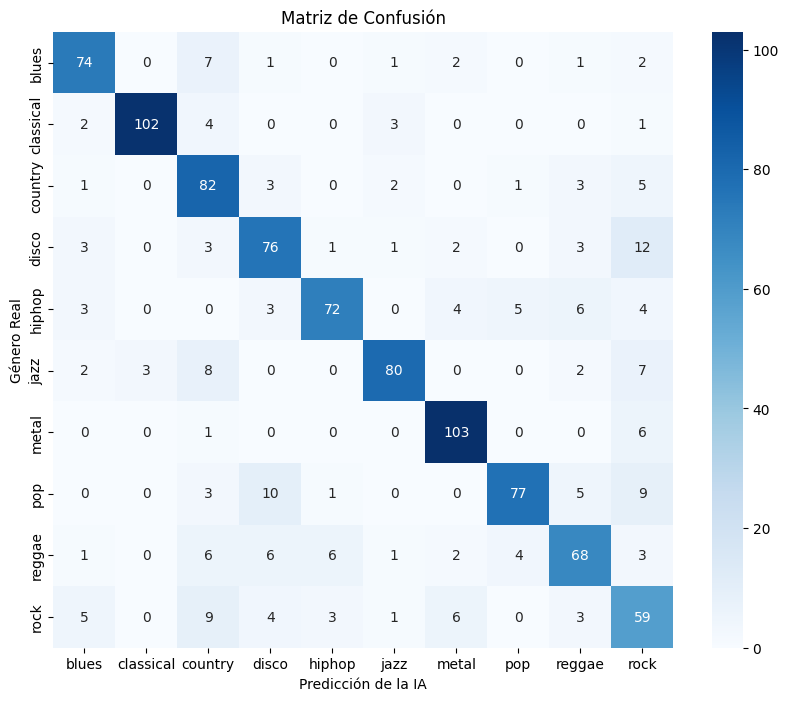

In [12]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize



# 1. Obtener predicciones del set de test
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# 2. Generar Matriz de Confusión
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, cmap='Blues')
plt.xlabel('Predicción de la IA')
plt.ylabel('Género Real')
plt.title('Matriz de Confusión')
plt.show()

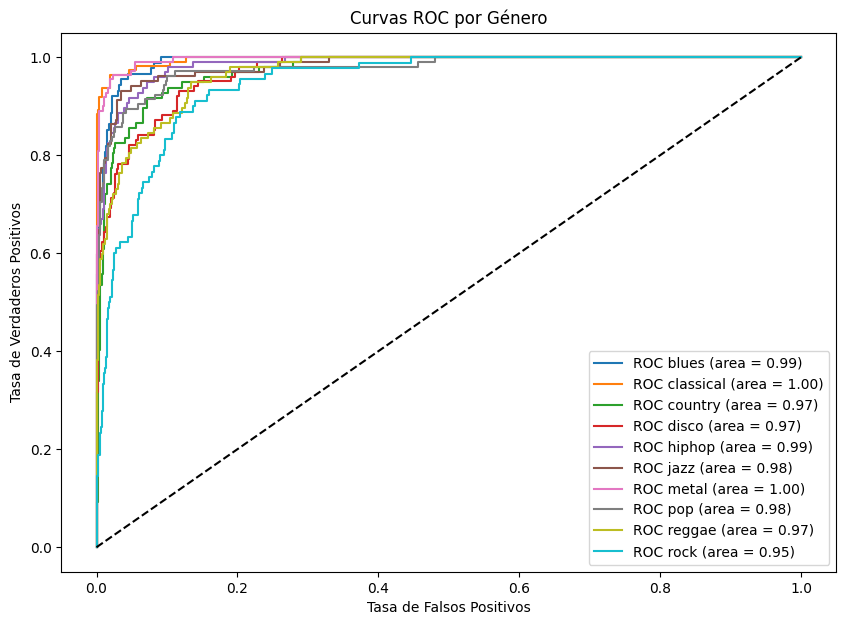

In [13]:
# 3. Curva ROC
y_test_binarized = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC {genres[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Género')
plt.legend(loc="lower right")
plt.show()

### 12. Inferencia con Música Real

En esta sección, subiremos un archivo de audio externo (MP3 o WAV) para evaluar la capacidad de predicción del modelo en un entorno real. El audio será procesado para extraer un segmento representativo y transformarlo en los mismos coeficientes MFCC utilizados durante el entrenamiento

In [15]:
from google.colab import files

# Esto abrirá un selector de archivos en tu navegador
uploaded = files.upload()

# Guardamos el nombre del archivo para usarlo después
filename = list(uploaded.keys())[0]
print(f"\nArchivo '{filename}' subido correctamente.")

Saving Mozart - Lacrimosa.mp3 to Mozart - Lacrimosa.mp3

Archivo 'Mozart - Lacrimosa.mp3' subido correctamente.


In [18]:
def predict_song(model, file_path):
    # 1. Cargar el audio (Librosa maneja MP3 automáticamente)
    # Usamos el Sample Rate original del proyecto (22050)
    signal, sr = librosa.load(file_path, sr=22050)

    # 2. Extraer un segmento de 3 segundos
    # Elegimos un fragmento del medio para evitar intros lentas o finales en silencio
    duration_to_extract = 3
    samples_per_segment = sr * duration_to_extract

    # Intentamos tomar el segmento del segundo 10 al 13
    start_sample = sr * 10
    finish_sample = start_sample + samples_per_segment

    # Verificamos que la canción sea lo suficientemente larga
    if len(signal) < finish_sample:
        start_sample = 0
        finish_sample = samples_per_segment

    segment = signal[start_sample:finish_sample]

    # 3. Extraer MFCC
    mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T # Transponer para tener el tiempo en el primer eje

    # 4. Ajustar dimensiones para la Red Neuronal (Lote, Tiempo, Coeficientes, Canal)
    # Esperado: (1, 130, 13, 1)
    mfcc = mfcc[np.newaxis, ..., np.newaxis]

    # 5. Predicción
    prediction = model.predict(mfcc, verbose=0)
    predicted_index = np.argmax(prediction, axis=1)[0]

    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

    print(f"\n" + "="*30)
    print(f"ANÁLISIS DE AUDIO FINALIZADO")
    print(f"="*30)
    print(f"PREDICCIÓN: {genres[predicted_index].upper()} 🎵")
    print(f"Confianza: {prediction[0][predicted_index]*100:.2f}%")
    print("-" * 30)


# Ejecutamos la predicción con el archivo que subiste
predict_song(model, filename)


ANÁLISIS DE AUDIO FINALIZADO
PREDICCIÓN: CLASSICAL 🎵
Confianza: 80.34%
------------------------------


### 13. Conclusión Final
En este proyecto de clasificación de audio, hemos pasado de un procesamiento de señal cruda (.wav) a una representación de ingeniería de características (MFCC) que permitió entrenar una CNN con éxito.

**Logros clave:**

**Arquitectura robusta:** Se controló el overfitting mediante Dropout 0.5, logrando una generalización del 79-80%.

**Análisis crítico:** Se identificó mediante Matrices de Confusión que las ambigüedades entre géneros (como Country vs Rock) son la principal limitación del dataset.

**Inferencia real:** El modelo demuestra una alta precisión en la identificación de géneros con timbres únicos como Classical y Metal.

Este proyecto sienta las bases para sistemas de recomendación musical más complejos o herramientas de etiquetado automático para bibliotecas de audio.

In [17]:
# Guardamos el modelo en formato estándar de Keras
model.save("clasificador_musical_gtzan.h5")
print("Modelo guardado como 'clasificador_musical_gtzan.h5'")

Modelo guardado como 'clasificador_musical_gtzan.h5'
